In [1]:
%run ../setup_notebook.ipynb

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/thijs/repos/dnp-code/PGM3_correct/source/numba_utilities.py:1109: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dmean_v_dw = np.dot(s1.T, V)
/home/thijs/repos/dnp-code/PGM3_correct/source/numba_utilities.py:1110: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  dvar_e_dw = np.dot(s2.T, V)
/home/thijs/repos/dnp-code/PGM3_correct/source/numba_utilities.py:1111: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, F), array(float32, 2d, A))
  tmp3 = np.dot(s3.T, V)
/home/thijs/repos/dnp-code/PGM3_correct/source/numba_utilities.py:946: NumbaPerformanceWar

/home/thijs/repos/dnp-code/rbm_pipeline_functions.py


/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (5553, 54334) is not recognized, so it cannot be loaded.
drifts with shape (5553, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (5553, 54334) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 54334) is not recognized, so it cannot be loaded.
segmentation with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
temporalmean with shape (30, 598, 1280) is not recognized, so it cannot be loaded.
rawsignal with shape (5553, 54334) is not recognized, so it cannot be loaded.
trace with shape (5553, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume/20180912_Run01_spontaneous_rbm2.h5
len test inds 1665


In [2]:
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar as mpl_colorbar
import plotting_functions as pf
import analysis_functions as af
import swap_sign_RBM as ssrbm
pf.set_fontsize(font_size=12)
%load_ext autoreload
%autoreload 2
# train_data['wb'].shape

## PCA & ICA

In [3]:
### PCA & ICA
all_nr_methods = []
weights = {}
# mapping = {}
# inverse_mapping = {}
n_comps = {'wb': 200}
bool_pca, bool_ica, bool_fa = True, False, False

def add_new_methods(name, region):
    assert weights[name].shape[0] < weights[name].shape[1]
    print(weights[name].shape, name)
#     mapping[name] = lambda high_data, w=weights[name]: np.dot(w, high_data)
#     inverse_mapping[name] = lambda low_data, w=weights[name].transpose(): np.dot(w, low_data)
    all_nr_methods.append(name)
#     low_dyn_test[name] = mapping[name](test_data[region])
#     low_dyn_train[name] = mapping[name](train_data[region])
#     low_dyn_full[name] = mapping[name](full_data[region])
    
for ir, r in enumerate(list(n_comps.keys())):
    if bool_pca:
        pca_model = sklearn.decomposition.PCA(n_components=n_comps[r])
        pca_model.fit(np.transpose(train_data[r]))
        print(pca_model)
        model_name = f'pca' 
        weights[model_name] = pca_model.components_
        add_new_methods(name=model_name, region=r)

    if bool_ica:
        ica_model = sklearn.decomposition.FastICA(n_components=n_comps[r])
        ica_model.fit(np.transpose(train_data[r]))
        print(ica_model)
        model_name = f'ica' 
        weights[model_name] = ica_model.components_
        add_new_methods(name=model_name, region=r)
    
    if bool_fa:
        fa_model = sklearn.decomposition.FactorAnalysis(n_components=n_comps[r])
        fa_model.fit(np.transpose(train_data[r]))
        print(fa_model)
        model_name = f'fa'
        weights[model_name] = fa_model.components_
        add_new_methods(name=model_name, region=r)

PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)
(200, 52518) pca


In [4]:
rbm_path = '/media/thijs/hooghoudt/new_sweep_april20/RBM_sweep_reruns/RBM3_20180912-Run01-spontaneous-rbm2_wb_test-segs-267-nseg10_M200_l1-2e-02_duration208093s_timestamp2020-05-16-0844.data'
tmp_RBM = pickle.load(open(rbm_path, 'rb'))
RBM = ssrbm.swap_sign_RBM(RBM=tmp_RBM, verbose=2)
weights['rbm'] = RBM.weights.copy()

45/200 HU weights are flipped
Flipped HUs are: (array([  1,  11,  12,  19,  30,  36,  37,  38,  41,  43,  52,  55,  67,
        68,  70,  72,  88,  94,  95,  99, 100, 107, 111, 117, 118, 120,
       124, 128, 133, 136, 138, 140, 151, 152, 167, 170, 171, 172, 175,
       177, 181, 186, 188, 191, 198]),)


In [5]:
plot_methods = [ 'pca', 'rbm']
weighted_labels = {}

plot_labels = rec.labels[inds_wb, :].A
ind_regions = set(np.where(plot_labels.sum(0))[0])
ind_regions = np.array(list(ind_regions.difference(set([0, 93, 113, 218, 219, 220, 221, 222, 223, 224, 259, 274]))))
plot_labels = np.squeeze(plot_labels[:, ind_regions])


sparsity_vector = {}
part_ratio_activity = {x: np.zeros(test_data['wb'].shape[1]) for x in ['rbm', 'pca']}
for dr in plot_methods:
    sparsity_vector[dr] = np.zeros(weights[dr].shape[0])
    for mu in range(weights['rbm'].shape[0]):
        weighted_labels[dr] = af.freq_distr_weighted_regions(w_vector=weights[dr][mu, :], m_labels=plot_labels)
        sparsity_vector[dr][mu] = af.p_metric_per_hu(weighted_labels[dr]) * len(weighted_labels[dr])
for t in range(test_data['wb'].shape[1]):
    pc_act = np.dot(weights['pca'], test_data['wb'][:, t])
    part_ratio_activity['pca'][t] = af.p_metric_per_hu(pc_act)
    hu_act = RBM.mean_hiddens(test_data['wb'][:, t].T)
    part_ratio_activity['rbm'][t] = af.p_metric_per_hu(hu_act)

In [ ]:
# plt.rcParams['figure.figsize'] = (5, 4)
# for k, v in part_ratio_activity.items():
#     plt.hist(v, bins=50, histtype='step', label=k)
# plt.legend()

In [86]:
## Uniformity of connectivity:

## Original metric:
# w_th_arr, curve_NVUgeqKw, sh_curve_NVUgeqKw = {}, {}, {}
# print(f'Methods: {plot_methods}')
# for dr in plot_methods:
#     print(f'calculating {dr}')
#     w_th_arr[dr], curve_NVUgeqKw[dr], sh_curve_NVUgeqKw[dr] = af.count_connections(weight_matrix=weights[dr],
#                                                                                 n_w_th=250, perc_top=100)

## New metric:
# all_w_arrs, all_sh_w_arrs, all_cdfs, all_sh_cdfs = {}, {}, {}, {}
degree_distr, sh_degree_distr = {}, {}
print(f'Methods: {plot_methods}')
for dr in plot_methods:
#     print(f'calculating {dr}')
#     all_w_arrs[dr], all_sh_w_arrs[dr], all_cdfs[dr], all_sh_cdfs[dr] = af.count_connections_3(weight_matrix=weights[dr],
#                                                                                 n_w_th=250)

    degree_distr[dr], sh_degree_distr[dr] = af.count_connections_3(weight_matrix=weights[dr])

Methods: ['pca', 'rbm']


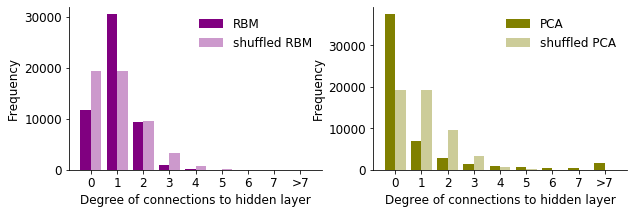

In [101]:
ax_rbm = plt.subplot(121)
ax_pca = plt.subplot(122)
pf.plot_degree_distr(degree_dict=degree_distr, 
                     degree_dict_sh=sh_degree_distr, ax=ax_rbm)
pf.plot_degree_distr(degree_dict=degree_distr, 
                     degree_dict_sh=sh_degree_distr, ax=ax_pca, dr='pca')


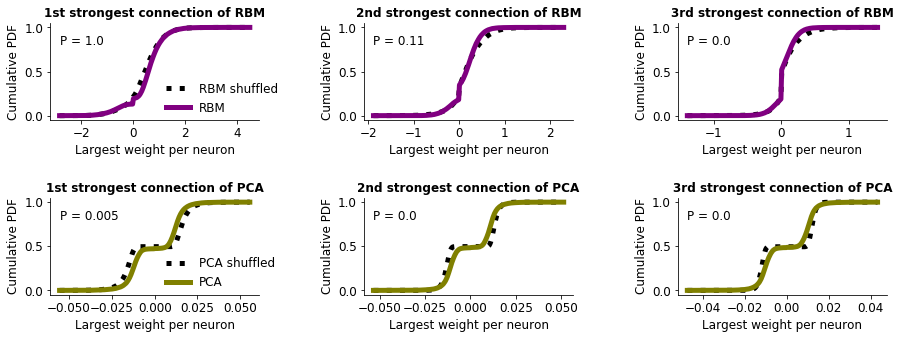

In [239]:
# ## Supplemental figure of uniform
# for dr in plot_methods:
#     for kk in range(all_cdfs[dr].shape[0]):
#         distr = all_cdfs[dr][kk, :]
#         sh_distr = all_sh_cdfs[dr][kk, :]
#         print(f'{dr}: K = {kk} P value = {np.round(scipy.stats.ks_2samp(distr, sh_distr)[1], 3)}')


# plt.rcParams['figure.figsize'] = (15, 5)
# plt.subplots_adjust(hspace=0.8, wspace=0.5)
# ax_unif_dict = {}
# dict_str_number = {0: '1st', 1: '2nd', 2: '3rd'}
# for i_dr, dr in enumerate(['rbm', 'pca']):
#     for i_k, k_value in enumerate([0, 1, 2]):
#         i_plot = 1 + i_k + (3 * i_dr)
#         ax_unif_dict[i_plot] = plt.subplot(2, 3, i_plot)
#         _ = pf.plot_uniform_distr(w_mat=all_w_arrs, sh_w_mat=all_sh_w_arrs,
#                                   cdf_mat=all_cdfs, sh_cdf_mat=all_sh_cdfs,
#                                   k_value=k_value, dr=dr, print_pval=True,
#                                   plot_legend=(i_k == 0), ax=ax_unif_dict[i_plot])

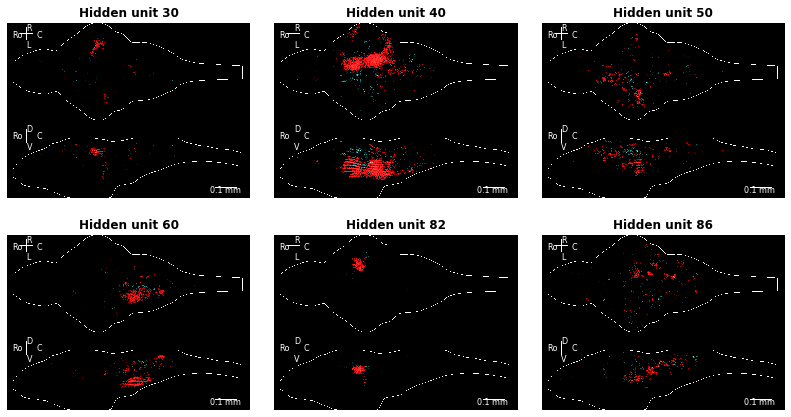

In [152]:
plt.rcParams['figure.figsize'] = (12, 6)
save_fig = False

mu_arr = [30, 40, 50, 60, 82, 86]

fig = plt.figure(constrained_layout=False)
gs_im = fig.add_gridspec(ncols=3, nrows=2, bottom=0.05, top=0.95, 
                         hspace=0.2, wspace=0.1, left=0.05, right=0.95)  # [1, 2.2, 1.2]

## example  plots
sax = {} 
for i_mu, mu in enumerate(mu_arr):
    sax[i_mu] = fig.add_subplot(gs_im[i_mu])
    pf.plot_example_hu(ax=sax[i_mu], hu_id=mu, fontsize=8)



if save_fig:
    plt.savefig('/home/thijs/repos/zf-rbm/figures/fig_2.pdf', dpi=500, bbox_inches='tight')

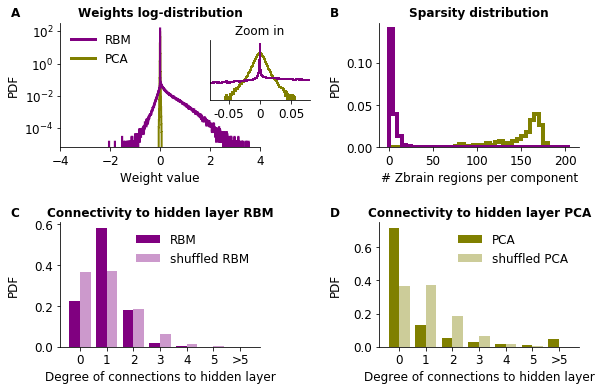

In [151]:
plt.rcParams['figure.figsize'] = (8, 5)
save_fig = True

fig = plt.figure(constrained_layout=False)
gs_stats = fig.add_gridspec(ncols=2, nrows=2, bottom=0.05, top=0.95, 
                         hspace=0.6, wspace=0.6, left=0.05, right=0.95) 


## Sparsity of regions
ax_spars = fig.add_subplot(gs_stats[1])
plot_bins = np.arange(0, len(ind_regions), 5)
for dr in plot_methods:
    #     plt.hist(sparsity_vector[dr], bins=plot_bins, label=dr)
    sns.distplot(sparsity_vector[dr], hist=True, kde=False, bins=plot_bins,
                 label=dr_legend[dr], color=dr_colors[dr], ax=ax_spars,
                 kde_kws={'linewidth': 4}, hist_kws={'histtype':'step', 'linewidth':4, 'alpha':1, 'density':True})  # prev alpha 0.7 lw 2
ax_spars.set_xlabel('# Zbrain regions per component'); 
ax_spars.set_ylabel('PDF'); 
ax_spars.set_title('Sparsity distribution', fontdict={'weight': 'bold'});
ax_spars.spines['top'].set_visible(False)
ax_spars.spines['right'].set_visible(False)

## Weights distribution
ax_mainw = fig.add_subplot(gs_stats[0])
plot_bins = np.linspace(np.min([weights[x].min() for x in weights.keys()]), 
                        np.max([weights[x].max() for x in weights.keys()]), 1000)
for dr in plot_methods:
    ax_mainw.hist(np.ravel(weights[dr]), bins=plot_bins, histtype='step', label=dr_legend[dr],
             density=True, linewidth=2, color=dr_colors[dr])
ax_mainw.set_yscale('log'); ax_mainw.set_xlabel('Weight value'); 
ax_mainw.set_ylabel('PDF'); 
ax_mainw.set_title('Weights log-distribution', fontdict={'weight': 'bold'})
ax_mainw.set_xlim([-4, 4])
ax_mainw.spines['top'].set_visible(False)
ax_mainw.spines['right'].set_visible(False)
handle_dict = {dr: matplotlib.lines.Line2D([], [], c=dr_colors[dr]) for dr in ['rbm', 'pca']}
ax_mainw.legend(handles=[handle_dict['rbm'], handle_dict['pca']],
                labels=[dr_legend['rbm'], dr_legend['pca']],
                frameon=False, loc='upper left');

## Weights distribution Zoom inset
ax_zoomw = ax_mainw.inset_axes([0.75, 0.38, 0.5, 0.48])
for dr in plot_methods:
    ax_zoomw.hist(np.ravel(weights[dr]), bins=np.linspace(-0.11, 0.11, 500), 
                  histtype='step', label=dr_legend[dr],
                  density=True, linewidth=2, color=dr_colors[dr])
ax_zoomw.get_yaxis().set_visible(False);
ax_zoomw.get_xaxis().set_ticklabels(['', '-0.05', '0', '0.05'])
ax_zoomw.set_yscale('log'); ax_zoomw.set_xlim([-0.08, 0.08]); 
ax_zoomw.set_ylim([1e-4, 5e3])
ax_zoomw.set_title('Zoom in')
ax_zoomw.spines['top'].set_visible(False)
ax_zoomw.spines['right'].set_visible(False)

## Uniformity plots
ax_unif = {}
for i_dr, dr in enumerate(['rbm', 'pca']):
    ax_unif[i_dr] = fig.add_subplot(gs_stats[2 + i_dr])
    pf.plot_degree_distr(degree_dict=degree_distr, degree_dict_sh=sh_degree_distr,
                         dr=dr, ax=ax_unif[i_dr], cutoff=6, normalise=True)
    

##  Alignment
fig.align_ylabels(axs=[ax_mainw, ax_unif[0]])
fig.align_ylabels(axs=[ax_spars, ax_unif[1]])
fig.align_xlabels(axs=[ax_spars, ax_mainw])
fig.align_xlabels(axs=[ax_unif[0], ax_unif[1]])

ax_mainw.annotate(s='A', xycoords='axes fraction', xy=(-0.25, 1.05), 
                  fontweight='bold')
ax_spars.annotate(s='B', xycoords='axes fraction', xy=(-0.25, 1.05), 
                  fontweight='bold')
ax_unif[0].annotate(s='C', xycoords='axes fraction', xy=(-0.25, 1.05), 
                  fontweight='bold')
ax_unif[1].annotate(s='D', xycoords='axes fraction', xy=(-0.25, 1.05), 
                  fontweight='bold')

if save_fig:
    plt.savefig('/home/thijs/repos/zf-rbm/figures/fig_hu_structure_stats.pdf', bbox_inches='tight')

In [153]:
hu_act_test = np.transpose(RBM.mean_hiddens(test_data['wb'].T))


ol = af.opt_leaf(hu_act_test)
hu_act_test_remap = hu_act_test[ol, :]

In [189]:
freq = 1 / np.mean(np.diff(rec.time))
print(f'frequency = {freq}')
median_hu_period = af.compute_median_state_occupancy(activity=hu_act_test_remap, freq=freq)
median_vu_period = af.compute_median_state_occupancy(activity=test_data['wb'], bimodality=0.5, freq=freq)  # binary data

frequency = 3.3003290254073083


In [190]:
median_hu_period

array([[        nan,         nan],
       [        nan,         nan],
       [ 0.60600019,  0.60600019],
       [ 0.60600019,  0.60600019],
       [ 0.60600019,  0.60600019],
       [ 0.90900028,  0.60600019],
       [ 1.21200037,  0.60600019],
       [ 1.51500046,  0.60600019],
       [ 0.90900028,  0.60600019],
       [ 3.9390012 ,  1.21200037],
       [ 0.90900028,  0.60600019],
       [ 0.90900028,  0.60600019],
       [ 1.21200037,  0.60600019],
       [ 1.21200037,  0.60600019],
       [ 1.81800056,  0.90900028],
       [ 1.21200037,  0.60600019],
       [ 2.12100065,  0.90900028],
       [ 3.03000093,  1.21200037],
       [ 2.27250069,  1.21200037],
       [ 1.36350042,  0.60600019],
       [ 2.42400074,  1.21200037],
       [ 1.21200037,  0.90900028],
       [ 3.03000093,  1.21200037],
       [ 2.42400074,  0.90900028],
       [ 1.81800056,  0.60600019],
       [ 0.90900028,  0.90900028],
       [ 1.51500046,  0.90900028],
       [ 2.42400074,  1.21200037],
       [ 1.21200037,

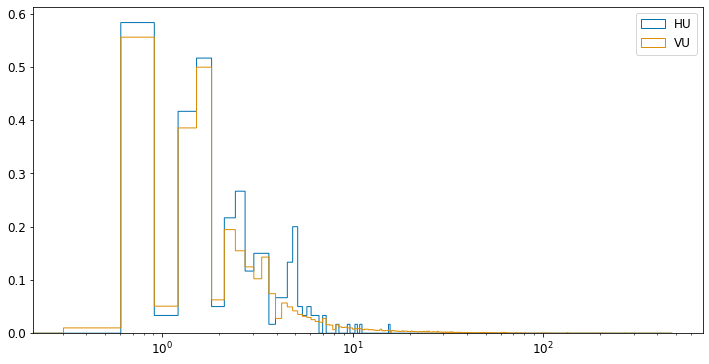

In [196]:
bin_array = np.arange(0, np.maximum(np.nanmax(median_hu_period[:, 0]),
                                 np.nanmax(median_vu_period[:, 0])) + 1,  1 / freq)
plt.hist(median_hu_period[:, 0], bins=bin_array, 
         density=True, label='HU', histtype='step')
plt.hist(median_vu_period[:, 0], bins=bin_array, 
         density=True, label='VU', histtype='step')
plt.legend()
plt.xscale('log')
# plt.yscale('log')

In [195]:
bin_array

array([], dtype=float64)

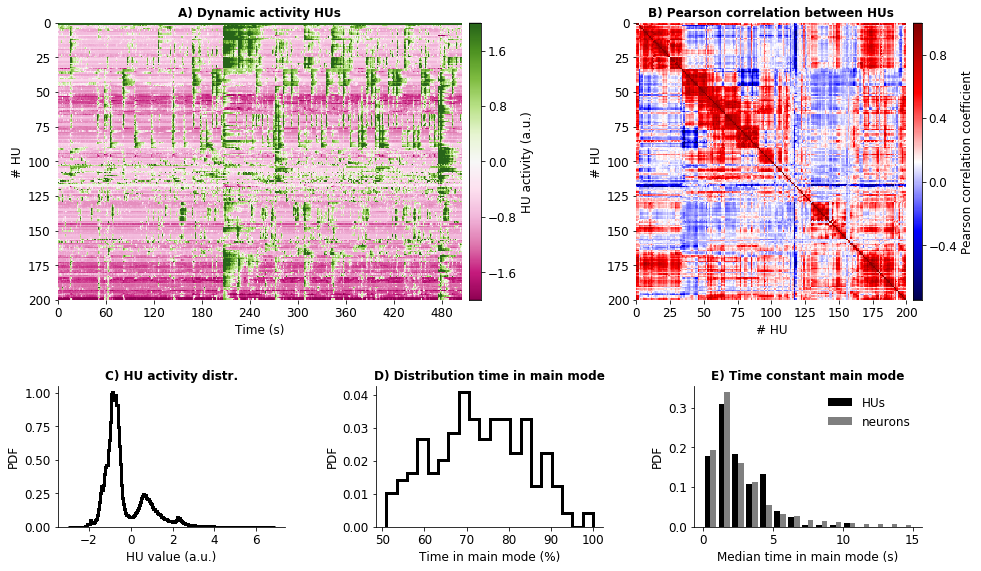

In [215]:
plt.rcParams['figure.figsize'] = (12, 7)
save_fig = True
# freq = 1 / np.mean(np.diff(rec.time))

fig = plt.figure(constrained_layout=False)
gs = {}
gs[0] = fig.add_gridspec(ncols=1, nrows=1, bottom=0.45, top=1, left=0, right=0.49)
gs[1] = fig.add_gridspec(ncols=1, nrows=1, bottom=0.45, top=1, left=0.67, right=1)
# gs[2] = fig.add_gridspec(ncols=1, nrows=6, bottom=0.0, top=0.5, left=0, right=0.49)
gs[2] = fig.add_gridspec(ncols=3, nrows=1, bottom=0, top=0.28, left=0, right=1, wspace=0.4)

## Dynamic activity raster plot
ax_raster = fig.add_subplot(gs[0][0])
sns.heatmap(hu_act_test_remap, vmin=-2, vmax=2, cbar=False, cmap='PiYG', ax=ax_raster)
ax_raster.set_yticks([x * 25 for x in range(9)])
ax_raster.set_yticklabels(ax_raster.get_yticks())
ax_raster.set_xticks([x * int(60 * freq) for x in range(9)])
ax_raster.set_xticklabels((np.round(ax_raster.get_xticks() / freq)).astype('int'),
                          rotation=0)
ax_raster.set_title('A) Dynamic activity HUs', fontdict={'weight': 'bold'})
ax_raster.set_xlabel('Time (s)'); ax_raster.set_ylabel('# HU')
divider = make_axes_locatable(ax_raster)
cax_rast = divider.append_axes('right', size='3%', pad=0.1)
mpl_colorbar(ax_raster.get_children()[0], cax=cax_rast)
cax_rast.yaxis.set_ticks_position('right')
cax_rast.set_ylabel(r'HU activity (a.u.)')

## Pearson correlation plot
ax_corr = fig.add_subplot(gs[1][0])
corr_mat_hus = np.corrcoef(hu_act_test_remap)
sns.heatmap(corr_mat_hus, cmap='seismic', cbar=False, ax=ax_corr)
ax_corr.set_title('B) Pearson correlation between HUs', fontdict={'weight': 'bold'})
ax_corr.set_xlabel('# HU'); ax_corr.set_ylabel('# HU');
ax_corr.set_xticks([x * 25 for x in range(9)])
ax_corr.set_xticklabels(ax_raster.get_yticks(), rotation=0)
ax_corr.set_yticks([x * 25 for x in range(9)])
ax_corr.set_yticklabels(ax_raster.get_yticks())
divider = make_axes_locatable(ax_corr)
cax_corr = divider.append_axes('right', size='3%', pad=0.1)
mpl_colorbar(ax_corr.get_children()[0], cax=cax_corr)
cax_corr.yaxis.set_ticks_position('right')
cax_corr.set_ylabel(r'Pearson correlation coefficient')

## Distirbution of HU activity
ax_hist_act = fig.add_subplot(gs[2][0])
ax_hist_act.hist(hu_act_test_remap.flatten(), bins=200, histtype='step', 
                 linewidth=3, color='k', density=True);
ax_hist_act.set_xlabel('HU value (a.u.)'); ax_hist_act.set_ylabel('PDF');
ax_hist_act.set_title('C) HU activity distr.', weight='bold')
ax_hist_act.spines['right'].set_visible(False)
ax_hist_act.spines['top'].set_visible(False)

##
ax_hist_reside_main = fig.add_subplot(gs[2][1])
fract_geq0 = (hu_act_test_remap >= 0).mean(1)  # fraction of time points where value >= 0 for each hu
fract_main = np.abs(fract_geq0 - 0.5) + 0.5  # mirror at 0.5 for all points below 0.5
ax_hist_reside_main.hist(fract_main * 100, bins=20, histtype='step', linewidth=3,
                         color='k', density=True)
ax_hist_reside_main.set_xlabel('Time in main mode (%)')
ax_hist_reside_main.set_ylabel('PDF');
ax_hist_reside_main.set_title('D) Distribution time in main mode', weight='bold')
ax_hist_reside_main.set_xticks([x * 10 for x in range(5, 11)])
ax_hist_reside_main.spines['right'].set_visible(False)
ax_hist_reside_main.spines['top'].set_visible(False)

ax_hist_inter_mainstate = fig.add_subplot(gs[2][2])
ax_hist_inter_mainstate.hist([median_hu_period[:, 0], median_vu_period[:, 0]], 
                             density=True, color=['k', color_cycle[7]],
                             bins=np.arange(np.nanmax(median_hu_period)),
                              linewidth=3, label=['HUs', 'neurons'])
# ax_hist_inter_mainstate.hist(median_vu_period[:, 0], density=True, 
#                              bins=np.arange(np.nanmax(median_hu_period)), label='neurons',
#                              histtype='step', color=color_cycle[6], alpha=0.6, linewidth=3)
# bw = 0.4
# ax_hist_inter_mainstate.bar(x=bin_array[:-1] - 0.5 * bw, width=bw, height=median_hu_period[:, 0],
#                              label='HUs', color='k')
# ax_hist_inter_mainstate.bar(x=bin_array[:-1] + 0.5 * bw, width=bw, height=median_vu_period[:, 0],
#                              label='neurons', color=color_cycle[7])


ax_hist_inter_mainstate.set_xlabel('Median time in main mode (s)')
ax_hist_inter_mainstate.set_ylabel('PDF')
ax_hist_inter_mainstate.set_title('E) Time constant main mode', weight='bold')
ax_hist_inter_mainstate.spines['right'].set_visible(False)
ax_hist_inter_mainstate.spines['top'].set_visible(False)
ax_hist_inter_mainstate.legend(loc='upper right', frameon=False)


# ax_hist_inter_sidestate = fig.add_subplot(gs[2][3])
# ax_hist_inter_mainstate.hist(median_hu_period[:, 1], density=True, 
#                              bins=np.arange(np.nanmax(median_hu_period)),
#                              histtype='step', color='k', alpha=0.7, linewidth=3)
# ax_hist_inter_sidestate.set_xlabel('Median time in alternative mode')
# ax_hist_inter_sidestate.set_ylabel('PDF')
# ax_hist_inter_sidestate.set_title('F) Time constant alternative mode', weight='bold')
# ax_hist_inter_sidestate.spines['right'].set_visible(False)
# ax_hist_inter_sidestate.spines['top'].set_visible(False)

if save_fig:
    plt.savefig('/home/thijs/repos/zf-rbm/figures/fig_dynamics.pdf', bbox_inches='tight')

In [210]:
len(bin_array[:-1] - 0.5 * bw)

# width=bw, height=
len(median_hu_period[:, 0])
                             

200

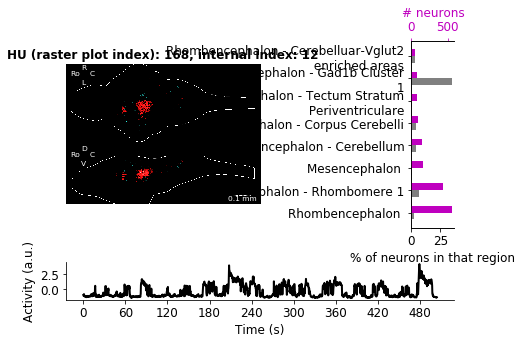

In [6]:
## Show one HU
tmp = pf.plot_info_hu(raster_order=ol, hu_activity=hu_act_test, mu=12, save_fig=False, region_absolute=True,
                          RBM=RBM, rec=rec, selection_neurons=selected_neurons['wb'])

In [7]:
## Save all Hidden Units 

plt.rcParams['figure.figsize'] = (10, 5)
for hu_ind in tqdm(range(200)):
    tmp = pf.plot_info_hu(raster_order=ol, hu_activity=hu_act_test, mu=hu_ind, save_fig=True,
                          region_absolute=False,
                          RBM=RBM, rec=rec, selection_neurons=selected_neurons['wb'])
    plt.close(tmp) # close to prevent plotting of all HUs

100%|██████████| 200/200 [04:01<00:00,  1.21s/it]


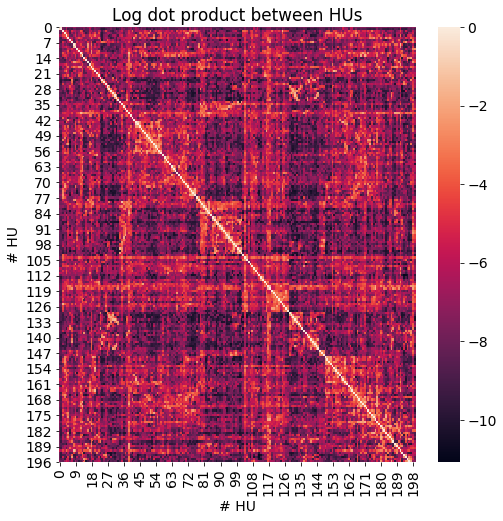

In [22]:
def adj_weights(weights):
    assert weights.shape[1] > weights.shape[0]
    tmp = np.abs(weights)
    mat = tmp.dot(tmp.T)
#     print(mat.shape)
    norm_els = np.diag(mat)
    norm_mat = norm_els[:, np.newaxis] + norm_els[np.newaxis, :]
    result = 2 * mat / norm_mat
#     np.fill_diagonal(result, 0.01)
    return result
    
adj_mat = adj_weights(RBM.weights[ol, :])

plt.rcParams['figure.figsize'] = (8, 8)
sns.heatmap(np.log(adj_mat))
plt.xlabel('# HU')
plt.ylabel('# HU')
plt.title('Log dot product between HUs');

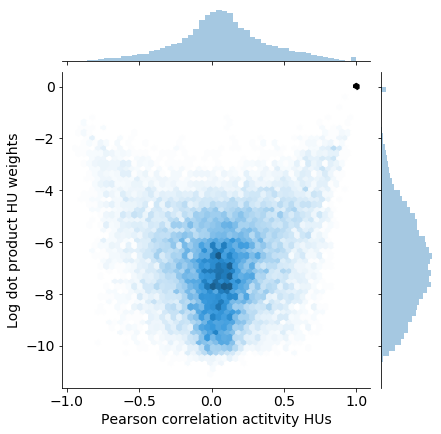

In [19]:

jp = sns.jointplot(corr_mat_hus.ravel(), np.log(adj_mat.ravel()), kind='hex')
jp.set_axis_labels('Pearson correlation actitvity HUs', 
                   'Log dot product HU weights')